In [15]:
%pylab 
from nugridpy import nugridse as mp
from nugridpy import mesa as ms
import matplotlib.pyplot as plt
import itertools
import copy
import os

# use h5py to read and write h5 file
import h5py

data_dir="/data/nugrid_apod2"    

ms.set_nugrid_path(data_dir)
mp.set_nugrid_path(data_dir)

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# (read in original data)
star = ms.star_log(mass=2.0,Z=0.02)

nugrid_path = /data/nugrid_apod2
closest set is set1.2 (Z = 0.02)
closest mass is 2.0
Using old star.logsa file ...
 reading ...100% 



<IPython.core.display.Javascript object>


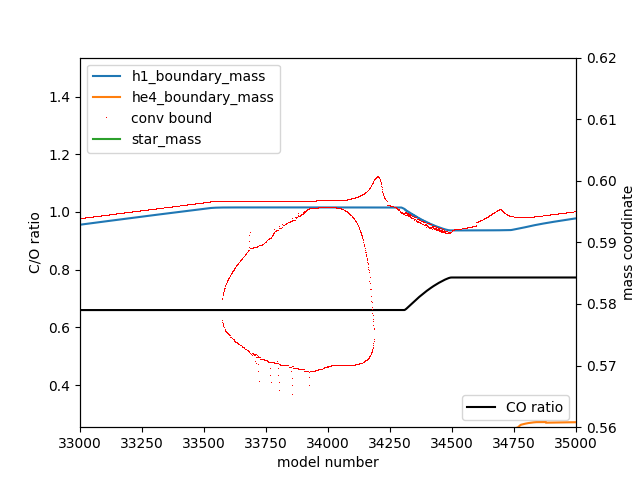

(0.56, 0.62)

In [20]:
# kippenhahn diagram for the thermal pulse of interest
plt.figure(1)
star.kippenhahn_CO(1,'model')

# set limits
plt.xlim([33000,35000])
plt.ylim([0.56,0.62])

## Prepare File I/O and star_log Arrays

In [4]:
# get the convection boundaries model numbers (restart at 33500, end 34250 (maybe earlier but change data to then))
cycle_start = 33500
cycle_end = 34250
cycle_split = 34000

# cycle strings
cycle_strings = []

# cycle template string
cycle_template = 'cycle{:>010d}'

# path to the files to be modified
path_h5 = '/user/ast501/dstephens/mppnp/diffusion_changes/h5_changes/'

# h5 file strings
file_string = [path_h5 + 'M2.00Z0.020.0033001.se.h5',path_h5 + 'M2.00Z0.020.0034001.se.h5']

##################################################################
# SINCE THESE ARE OVER TWO DIFFERENT SE FILES, MARK AND SPLIT WHERE THIS OCCURS
cycles = []

# loop over all models FOR FIRST FILE
for i in range(1 + cycle_split - cycle_start):
    cycle_strings.append(cycle_template.format(cycle_start + i))

# have the list within another list
cycles.append(cycle_strings)
cycle_strings = []

# loop over all models FOR SECOND FILE
for i in range(cycle_end - cycle_split):
    cycle_strings.append(cycle_template.format(cycle_split + 1 + i))

cycles.append(cycle_strings)

# slice arg (need to read appropriate index for each model number being written)
s_arg1 = [(cycle_start - 1), cycle_split]
s_arg2 = [cycle_split,cycle_end]

# get the star_log arrays and slice to appropriate 
star_mass = [star.get('star_mass')[s_arg1[0]:s_arg1[1]], star.get('star_mass')[s_arg2[0]:s_arg2[1]]]

# get mix mass coordinates
mix_bot = [star.get('mx2_bot')[s_arg1[0]:s_arg1[1]] * star_mass[0],
           star.get('mx2_bot')[s_arg2[0]:s_arg2[1]] * star_mass[1]]
             
mix_top = [star.get('mx2_top')[s_arg1[0]:s_arg1[1]] * star_mass[0],
           star.get('mx2_top')[s_arg2[0]:s_arg2[1]] * star_mass[1]]
  
# this is used to make sure diffusion coefficient doesn't extend this far (it's boundary of operation)
mix_Hshell = [star.get('mx1_bot')[s_arg1[0]:s_arg1[1]] * star_mass[0],
             star.get('mx1_bot')[s_arg2[0]:s_arg2[1]] * star_mass[1]]          

## Constants (SI)

In [5]:
Msun = 1.989e30
Rsun = 6.957e8

alpha = 1.6
fcbm_low = 0.015
fcbm_high = 0.03

## Functions

All functions will assume that the arrays have been inverted such that r[0] = 0!

### Boundary Functions

In [6]:
def schwarz(mix_bot,mix_top,mix_Hshell,mass):
    
    # find the elements corresponding to the schwarzschild boundary
    schwarz_bounds = [np.argmin(abs(mass - mix_bot)),np.argmin(abs(mass - mix_top))]
    hshell_bounds = np.argmin(abs(mass - mix_Hshell))
    
    return schwarz_bounds, hshell_bounds

def r0(schwarz_bounds,pressure,radius,fcbm_high,fcbm_low):
    
    # P and R are total sized arrays, use schwarz bounds to get the scale height there
    P_low = pressure[schwarz_bounds[0]:(schwarz_bounds[0]+2)]
    R_low = radius[schwarz_bounds[0]:(schwarz_bounds[0]+2)]
    scale_low = scale_height(P_low,R_low)
    
    P_high = pressure[schwarz_bounds[1]:(schwarz_bounds[1]+2)]
    R_high = radius[schwarz_bounds[1]:(schwarz_bounds[1]+2)]
    scale_high = scale_height(P_high,R_high)
    
    # get the values of r0
    r0_lower = radius[schwarz_bounds[0]] + fcbm_low * scale_low
    r0_upper = radius[schwarz_bounds[1]] - fcbm_high * scale_high
    
    # find the indices that these occur at
    r0_bounds = [np.argmin(abs(r0_lower - radius)),np.argmin(abs(r0_upper-radius))]
    
    # make sure indices make sense (not at schwarzschild or outside of it!)
    if r0_bounds[0] <= schwarz_bounds[0]:
        
        # set r0 to just inside convection zone
        r0_bounds[0] = schwarz_bounds[0] + 1
        
    if r0_bounds[1] >= schwarz_bounds[1]:
        
        # set r0 to just inside convection zone
        r0_bounds[1] = schwarz_bounds[1] - 1
        
    # return bounds and lower scale height (used for vmlt)
    return r0_bounds, scale_low

def diffusion_bounds(schwarz_bounds, hshell_bounds, diffusion):
    
    # the diffusion bounds should be in the vicinity of the schwarz bounds
    # but must be careful not to tread too far to the H-shell convection
    diff_bounds = []
    
    # look for the lower boundary, choose to start from schwarz bounds and go down
    counter = 0
    
    while diffusion[schwarz_bounds[0] - counter] > 1:
        counter += 1
    
    # store the lower boundary
    diff_bounds.append(schwarz_bounds[0] - counter)
    
    # look for the upper boundary
    counter = 0
    flag = 1
    
    while flag:
        
        # keep iterating
        if diffusion[schwarz_bounds[1] + counter] > 1:

            # make sure we haven't gone into the next shell
            if (schwarz_bounds[1] + counter) >= hshell_bounds:

                # not good, for now get a print statement and set it to 10 indices past (arbitrary)
                print 'WARNING: diffusion_bounds has iterated to the Hshell'
                
                # make sure you can exit loop
                flag = 0
                
                # make sure 10 isn't too far back
                if schwarz_bounds[1] + 10 >= hshell_bounds:
                    counter = 4
                else:
                    counter = 10

            else:
                counter += 1
        
        # set flag to zero
        else:
            flag = 0
    
    # store the upper boundary
    diff_bounds.append(schwarz_bounds[1] + counter)
    
    # return
    return diff_bounds

### Quantity Functions

In [7]:
def scale_height(pressure,radius):
    
    # this should a 2 len array so the scale height corresponds to itself at point R[0]
    return - np.power(np.diff(pressure) / np.diff(radius),-1) * pressure[0]

def vmlt(r0_bounds,diffusion,alpha,Hp0):
    
    # slice the diffusion array and get vmlt across the stable zone
    v_mlt = 3 * diffusion[r0_bounds[0]:(r0_bounds[1]+1)] / (alpha * Hp0)
    
    # return vmlt
    return v_mlt

def DRCMD(radius,r0_bounds,v_mlt,alpha,Hp0):
    
    # this function will return an array of values which is the modified diffusion coefficient
    # slice the radius array
    radius_D = radius[r0_bounds[0]:(r0_bounds[1]+1)]
    radius_r0_low = radius[r0_bounds[0]]
    radius_r0_high = radius[r0_bounds[1]]
    
    diffusion = []
    
    # r -rsc needs to be symmetric about the mid radius point, get median point
    med_radius = np.median(radius_D)
    med_index = np.argmin(abs(med_radius - radius_D))
    
    # loop over all radii
    for i in range(len(radius_D)):
        
        # r -rsc needs to be symmetric about the mid radius point
        if i < med_index:
            diffusion.append(v_mlt[i] * min(alpha * Hp0, abs(radius_D[i] - radius_r0_low)))
        else:
            diffusion.append(v_mlt[i] * min(alpha * Hp0, abs(radius_D[i] - radius_r0_high)))
    
    # return
    return diffusion

def overshoot(D0,r0,r,fcbm,Hp):
    
    # Hp is at r0 as well! (NOT at bottom of schwarzschild), this is the convective overshoot
    return D0 * np.exp(- 2 * abs(r - r0) / (fcbm * Hp))

## Change Diffusion Coefficient

In [16]:
# bool on whether to convert the SE H5 files or just read through them
convert = 1

# write a text file saying that it has been changed, else remove if there is a file
if convert:
    
    # create a file
    txt = open(path_h5 + 'DIFFUSION_CHANGE','w')
    txt.write('Diffusion coefficient has been changed')
    txt.close()
    
else:
    
    if os.path.isfile(path + 'DIFFUSION_CHANGE'):
        
        # delete file
        os.remove(path + 'DIFFUSION_CHANGE')
    
# store some values for debugging
model_change = []
mass_backup = []
diff_backup = []
schwarz_backup = []
mix_backup = []

mass_diff_change = []
diff_diff_change = []
temperature_mix = []

# loop through all files (split into 2)
for i in range(len(cycles)):
    
    # close previous file
    if i != 0:
        # close previous file
        data_file.close()
        
    # open the h5 file
    data_file = h5py.File(file_string[i])
    
    # loop through all cycles
    for p in range(len(cycles[i])):
        
        # FIRST determine if the model even has the convection zone
        if mix_bot[i][p] <= 1e-9:
            
            # there is no diffusion coefficient to change, exit
            temperature_mix.append(0)
            continue
        
        # if looking at the last few models, there are bugs of some sort in which the diffusion coefficient 
        # extends beyond the schwarzschild boundary(perhaps ledoux, depends on how the mx2* were calculated)
        # and so there is diffusion out there. The deviations of changes of diffusion become significant by the 
        # time the cycles[i][p] are p >= 180. This is a temporary measure, shouldn't be a big deal though
        elif i == 1 and p >= 180:

            # there is no diffusion coefficient to change, exit
            temperature_mix.append(0)
            continue
            
        else:
                
            # store the INDEX NUMBER
            if i == 0:
                model_change.append(cycle_start - 1 + p)
            else:
                model_change.append(cycle_split + p)

            # grab the needed data (pressure, radius, mass, diffusion) Radius is in cm?
            # MAKE DEEP COPIES, so nothing changes in the original data
            diffusion = np.flip(data_file[cycles[i][p]]['SE_DATASET']['dcoeff'],0)
            mass = np.flip(data_file[cycles[i][p]]['SE_DATASET']['mass'],0)
            radius = np.flip(data_file[cycles[i][p]]['SE_DATASET']['radius'],0) 
            pressure = np.flip(data_file[cycles[i][p]]['SE_DATASET']['pressure'],0)
            temperature = np.flip(data_file[cycles[i][p]]['SE_DATASET']['temperature'],0)
            
            # store some values for analysis (DEEP COPIES)
            if i == 1:
                mass_backup.append(np.copy(mass))
                diff_backup.append(np.copy(diffusion))
            
            # determine the schwarzschild boundaryand hshell limit
            schwarz_bounds, hshell_bounds = schwarz(mix_bot[i][p],mix_top[i][p],mix_Hshell[i][p],mass)

            # determine the r0 boundaries
            r0_bounds, Hp0 = r0(schwarz_bounds,pressure,radius,fcbm_high,fcbm_low)
            
            # get the diffusion boundaries
            diff_bounds = diffusion_bounds(schwarz_bounds,hshell_bounds,diffusion)
            
            # get the v_mlt array all the way to the overshoot limit
            v_mlt = vmlt(r0_bounds,diffusion,alpha,Hp0)
            
            #####################################################################
            #
            # MODIFY DIFFUSION
            #
            #####################################################################
            
            # first get within the r0 boundaries
            diffusion_rcmd = DRCMD(radius,r0_bounds,v_mlt,alpha,Hp0)
            
            # get the r0's
            r0_lower = radius[r0_bounds[0]]
            r0_upper = radius[r0_bounds[1]]
            
            # get the radii for overshoot
            radius_low = radius[diff_bounds[0]:r0_bounds[0]]
            radius_high = radius[(r0_bounds[1] + 1):(diff_bounds[1]+1)]
            
            # get the scale heights at the r0 boundaries
            P_low = pressure[r0_bounds[0]:(r0_bounds[0]+2)]
            R_low = radius[r0_bounds[0]:(r0_bounds[0]+2)]
            
            Hp_low = scale_height(P_low,R_low)
            
            P_high = pressure[r0_bounds[1]:(r0_bounds[1]+2)]
            R_high = pressure[r0_bounds[1]:(r0_bounds[1]+2)]
            
            Hp_high = scale_height(P_high,R_high)
            
            # get the overshoot in the lower bounds
            diffusion_lower = overshoot(diffusion_rcmd[0],r0_lower,radius_low,fcbm_low,Hp_low)
            diffusion_upper = overshoot(diffusion_rcmd[-1],r0_upper,radius_high,fcbm_high,Hp_high)
            
            # stitch together
            new_diffusion = list(itertools.chain(diffusion_lower,diffusion_rcmd,diffusion_upper))
            
            # change the original diffusion
            diffusion_slice = diffusion[diff_bounds[0]:(diff_bounds[1]+1)]
            mass_slice = mass[diff_bounds[0]:(diff_bounds[1]+1)]
            
            # check if the conversion is being done,
            if convert:
                
                # check if it is i == 0, p last
                if i == 0 and p == len(cycles[i]) - 1:
                    
                    # need to hold the diffusion changes, these need to be applied to file 34001 on model
                    # number 34000 and MUST BE DEEPCOPIES
                    temp_diff_bounds = copy.deepcopy(diff_bounds)
                    temp_new_diffusion = copy.deepcopy(new_diffusion)
                    
                # check if it is i ==1 and p == 0
                elif i == 1 and p == 0:
                    
                    # need to rewrite 34000
                    temp_diffusion = np.flip(data_file[cycles[0][-1]]['SE_DATASET']['dcoeff'],0)
                    temp_diffusion[temp_diff_bounds[0]:(temp_diff_bounds[1]+1)] = temp_new_diffusion
                    
                    # actually rewrite
                    data_file[cycles[0][-1]]['SE_DATASET']['dcoeff'] = np.flip(temp_diffusion,0)
                    
                # convert diffusion
                diffusion[diff_bounds[0]:(diff_bounds[1] + 1)] = new_diffusion
                
                # re flip it so that it matches original data structure
                data_file[cycles[i][p]]['SE_DATASET']['dcoeff'] = np.flip(diffusion,0)
                
            # store these values for analysis
            if i == 1:
                
                # get mass and diffusion changes
                mass_diff_change.append(copy.deepcopy(mass_slice))
                diff_diff_change.append(copy.deepcopy(new_diffusion))
                
                # get the schwarzschild boundaries and the mixing
                schwarz_backup.append(copy.deepcopy(schwarz_bounds))
                mix_backup.append([mix_bot[i][p],mix_top[i][p]])
                
            temperature_mix.append(temperature[schwarz_bounds[0]])

# Everything has been done, close file
data_file.close()

TypeError: coercing to Unicode: need string or buffer, file found

## Analysis on Data Obtained

Make a check to make sure the data was not only overwritten, but correctly by checking it against a false model.

The diffusion coefficient varies from the mesa model as the schwarzschild boundary is not what is constraining the boundaries of it as seen in the example below

In [9]:
print mix_backup[-1]
print schwarz_backup[-1]
print star.get('conv_mx2_top')[model_change[-1] ] * star.get('star_mass')[model_change[-1] ]
print star.get('conv_mx2_bot')[model_change[-1] ] * star.get('star_mass')[model_change[-1] ]
# print mass_backup[-1][schwarz_backup[-1][0]]

[0.57251719749027374, 0.57830634738037712]
[750, 834]
0.577623745796
0.572837406316


In [10]:
# re open the h5 file
h5_file = h5py.File(file_string[1])

# find where the last model is, and make the string for cycle
cycle_model_end = 'cycle00000' + str(model_change[-1] + 1)

modified_diffusion_h5 = np.flip(h5_file[cycle_model_end]['SE_DATASET']['dcoeff'],0)
mass_h5 = np.flip(h5_file[cycle_model_end]['SE_DATASET']['mass'],0)

<IPython.core.display.Javascript object>


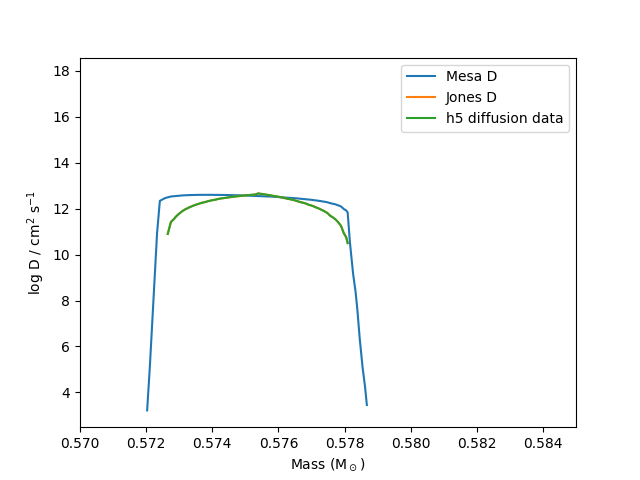

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


In [11]:
# make plot of last diffusion coefficient found
plt.figure(4)
plt.plot(mass_backup[-1],np.log10(diff_backup[-1]),label='Mesa D')
plt.plot(mass_diff_change[-1],np.log10(diff_diff_change[-1]),label='Jones D')
plt.plot(mass_h5,np.log10(modified_diffusion_h5),label='h5 diffusion data')
plt.xlim([0.57,0.585])

# labels
plt.xlabel('Mass (M$_\odot$)')
plt.ylabel('log D / cm$^{2}$ s$^{-1}$')

plt.legend()

In [12]:
# look at the temperature at the minimum step time
time = 10**(star.get('log_dt')) * 365.25
model_number = star.get('model_number')
L_He = star.get('log_LHe')
        
# slice arrays
model_number = model_number[(cycle_start-1):cycle_end]
time = time[(cycle_start-1):cycle_end]
L_He = L_He[(cycle_start-1):cycle_end]

<IPython.core.display.Javascript object>


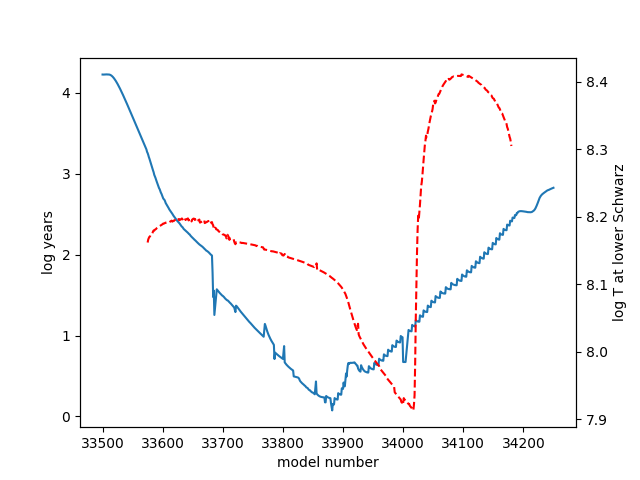

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


In [13]:
# plot log years and temp vs model
fig = plt.figure(7)
ax1 = fig.add_subplot(111)

# plot log years
ax1.plot(model_number,np.log10(time),label='log years')
ax1.set_xlabel('model number')
ax1.set_ylabel('log years')

ax2 = ax1.twinx()

ax2.plot(model_number,np.log10(temperature_mix),'r--',label='T at lower Schwarz')
ax2.set_ylabel('log T at lower Schwarz')


<IPython.core.display.Javascript object>


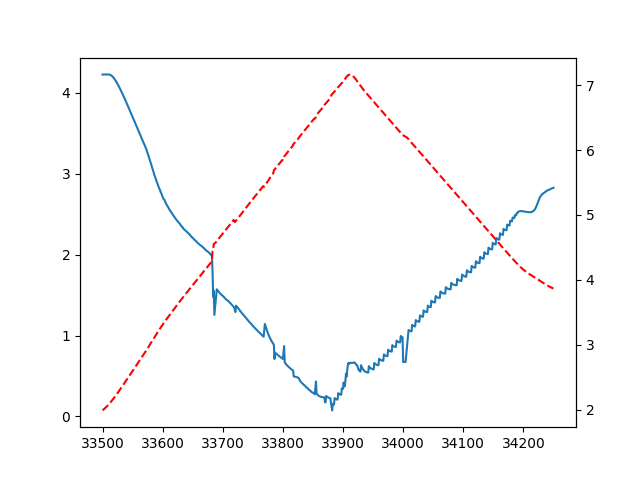

In [14]:
# plot log years and temp vs model
fig = plt.figure(8)
ax1 = fig.add_subplot(111)

# plot log years
ax1.plot(model_number,np.log10(time))

ax2 = ax1.twinx()

ax2.plot(model_number,L_He,'r--')
ax2.set_ylabel('')